In [1]:
# 5 Bayesian Linear Regression

In [2]:
# Task 10

In [3]:
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# Loads data
dat_file = open('seoul+bike+sharing+demand/SeoulBikeData.csv', 'r')
file_lines = dat_file.read().split("\n")
dat_file.close
file_lines = file_lines[:-1] # Last line of file is empty with split method so removed
features = file_lines[0].split(",")
label_name = "Rented Bike Count"
features = ["Date", "Hour", "Temperature", "Humidity", "Wind speed", "Visibility", "Dew point temperature",
           "Solar Radiation", "Rainfall", "Snowfall", "Seasons", "Holiday", "Functioning Day"]
file_lines = file_lines[1:] # Removes feature info

In [5]:
from datetime import datetime
import numpy as np
# Loads data into nd array
no_features = len(features)
no_data_items = len(file_lines)
X = np.ones((no_data_items, no_features))
# Loads date into array. Date is encoded as day number of year (1 = 1st January, 365 = 31st December).
# Note this ignores the year variable from dataset, however given that the dataset spans exatcly one year,
# no meaningful inference can be drawn from it.
for idx, record in enumerate(file_lines):
    date_str = record.split(",")[0]
    date_object = datetime.strptime(date_str, "%d/%m/%Y")
    day_number = date_object.timetuple().tm_yday
    X[idx, 0] = day_number

In [6]:
# Loads y labels (i.e. bikes rented)
Y = np.zeros(no_data_items)
for idx, record in enumerate(file_lines):
    Y[idx] = record.split(",")[1]

In [7]:
# Loads numerical objects into x that do not need any conversion
# Loads hour, temperature, humidity, wind speed, visibility, dew point, solar radiation, rainfall and snowfall
for idx, record in enumerate(file_lines):
    split_line = record.split(",")
    for feature_idx in range(2, 10 + 1):
        X[idx, feature_idx - 1] = split_line[feature_idx]

In [8]:
# Loads season data in. 1 = Spring, 2 = Summer, 3 = Autumn, 4 = Winter
for idx, record in enumerate(file_lines):
    season_str = record.split(",")[11]
    if season_str == "Spring": X[idx, 10] = 1
    elif season_str == "Summer": X[idx, 10] = 2
    elif season_str == "Autumn": X[idx, 10] = 3
    elif season_str == "Winter": X[idx, 10] = 4     

In [9]:
# Encodes holiday. 0 = No holiday, 1 = Holiday
for idx, record in enumerate(file_lines):
    hol_str = record.split(",")[12]
    if hol_str == "No Holiday": X[idx, 11] = 0
    elif hol_str == "Holiday": X[idx, 11] = 1

In [10]:
# Encodes function day. 0 = not functioning day, 1 = Functioning day
for idx, record in enumerate(file_lines):
    func_str = record.split(",")[13]
    if func_str == "Yes": X[idx, 12] = 1
    elif func_str == "No" : X[idx, 12] = 0

In [11]:
# Removes all non functioning days. Prediction for this is as simple as
# no bikes are sold on non-functioning days. Including this would needelessly skew the model
X_cpy = []
for idx in range(len(X)):
    if X[idx,12] == 1:
        X_cpy.append(X[idx])
# Removes functioning day column as it's now always true
X = np.delete(X, 12, 1)
features.remove("Functioning Day")

In [12]:
# Removes season data as weather readings encode most of this information well
X = np.delete(X, 10, 1)
features.remove("Seasons")

In [13]:
# Removes date from model as other information encodes this well enough
X = np.delete(X, 0, 1)
features.remove("Date")

In [14]:
# Task 11 + 12 - Makes model and chooses priors. Then trains BLR model
with pm.Model(coords={"predictors": features}) as model:
    hour_coff = pm.Normal("Hour", mu=0, sigma=20)
    temp_coff = pm.Normal("Temperature", mu=10, sigma=2)
    humid_coff = pm.Normal("Humidity", mu=-4, sigma=20)
    wind_coff = pm.Normal("Wind speed", mu=-10, sigma=2)
    vis_coff = pm.Normal("Visibility", mu=5, sigma=10)
    dew_coff = pm.Normal("Dew point temperature", mu=-4, sigma=20)
    sol_coff = pm.Normal("Solar radiation", mu=10, sigma=10)
    rain_coff = pm.Normal("Rainfall", mu=-20, sigma=2)
    snow_coff = pm.Normal("Snowfall", mu=-50, sigma=1)
    hol_coff = pm.Normal("Holiday", mu=-1, sigma=3)
    sig = pm.HalfNormal("Sigma", sigma=2)
    intercept = pm.Normal("Intercept", mu=0, sigma=20)
    coff_arr = [hour_coff, temp_coff, humid_coff, wind_coff, vis_coff, dew_coff, sol_coff,
               rain_coff, snow_coff, hol_coff]

    # Amounts to  bikes_pred_mu = (np.matmul(coff_arr, X.transpose()) + intercept).transpose()
    bikes_pred_mu = (coff_arr[0]*X[:,0]+coff_arr[1]*X[:,1]+coff_arr[2]*X[:,2]+coff_arr[3]*X[:,3]+coff_arr[4]*X[:,4]+
                coff_arr[5]*X[:,5]+coff_arr[6]*X[:,6]+coff_arr[7]*X[:,7]+coff_arr[8]*X[:,8] +
                coff_arr[9]*X[:,9])
    bikes = pm.Normal('bikes', mu=bikes_pred_mu, sigma=sig, observed=Y)
    # Performs BLR
    idata = pm.sample(1000, step=pm.NUTS(), progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Hour, Temperature, Humidity, Wind speed, Visibility, Dew point temperature, Solar radiation, Rainfall, Snowfall, Holiday, Sigma, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 201 seconds.


In [15]:
# Plots model summary
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Hour,29.34,0.44,28.54,30.17,0.01,0.01,3788.96,3217.23,1.0
Temperature,38.49,0.83,36.85,40.02,0.02,0.02,1478.71,2119.14,1.0
Humidity,-2.67,0.10,-2.86,-2.48,0.00,0.00,2720.49,2748.06,1.0
Wind speed,-4.90,1.73,-7.97,-1.47,0.03,0.02,4670.26,2754.59,1.0
Visibility,0.07,0.01,0.06,0.08,0.00,0.00,1797.64,2038.92,1.0
Dew point temperature,-10.15,0.78,-11.54,-8.64,0.02,0.01,1437.36,1934.01,1.0
Solar radiation,-43.66,3.98,-51.39,-36.60,0.07,0.05,2995.69,2829.93,1.0
Rainfall,-35.85,1.61,-38.90,-32.87,0.02,0.02,5124.89,2747.78,1.0
Snowfall,-48.71,0.95,-50.43,-46.84,0.01,0.01,5325.90,3020.14,1.0
Holiday,-8.61,2.89,-13.76,-3.11,0.04,0.03,4426.48,2797.63,1.0


array([[<AxesSubplot:title={'center':'Hour'}>,
        <AxesSubplot:title={'center':'Hour'}>],
       [<AxesSubplot:title={'center':'Temperature'}>,
        <AxesSubplot:title={'center':'Temperature'}>],
       [<AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'Humidity'}>],
       [<AxesSubplot:title={'center':'Wind speed'}>,
        <AxesSubplot:title={'center':'Wind speed'}>],
       [<AxesSubplot:title={'center':'Visibility'}>,
        <AxesSubplot:title={'center':'Visibility'}>],
       [<AxesSubplot:title={'center':'Dew point temperature'}>,
        <AxesSubplot:title={'center':'Dew point temperature'}>],
       [<AxesSubplot:title={'center':'Solar radiation'}>,
        <AxesSubplot:title={'center':'Solar radiation'}>],
       [<AxesSubplot:title={'center':'Rainfall'}>,
        <AxesSubplot:title={'center':'Rainfall'}>],
       [<AxesSubplot:title={'center':'Snowfall'}>,
        <AxesSubplot:title={'center':'Snowfall'}>],
       [<AxesSubplot:title=

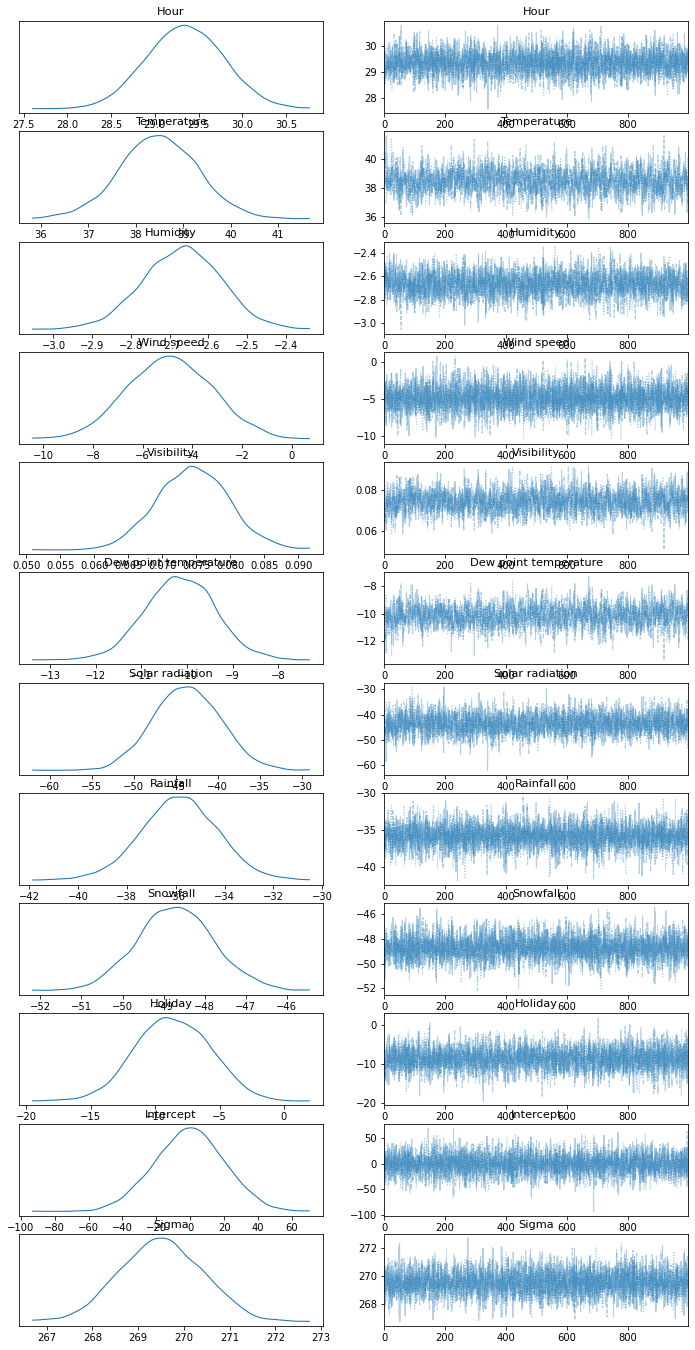

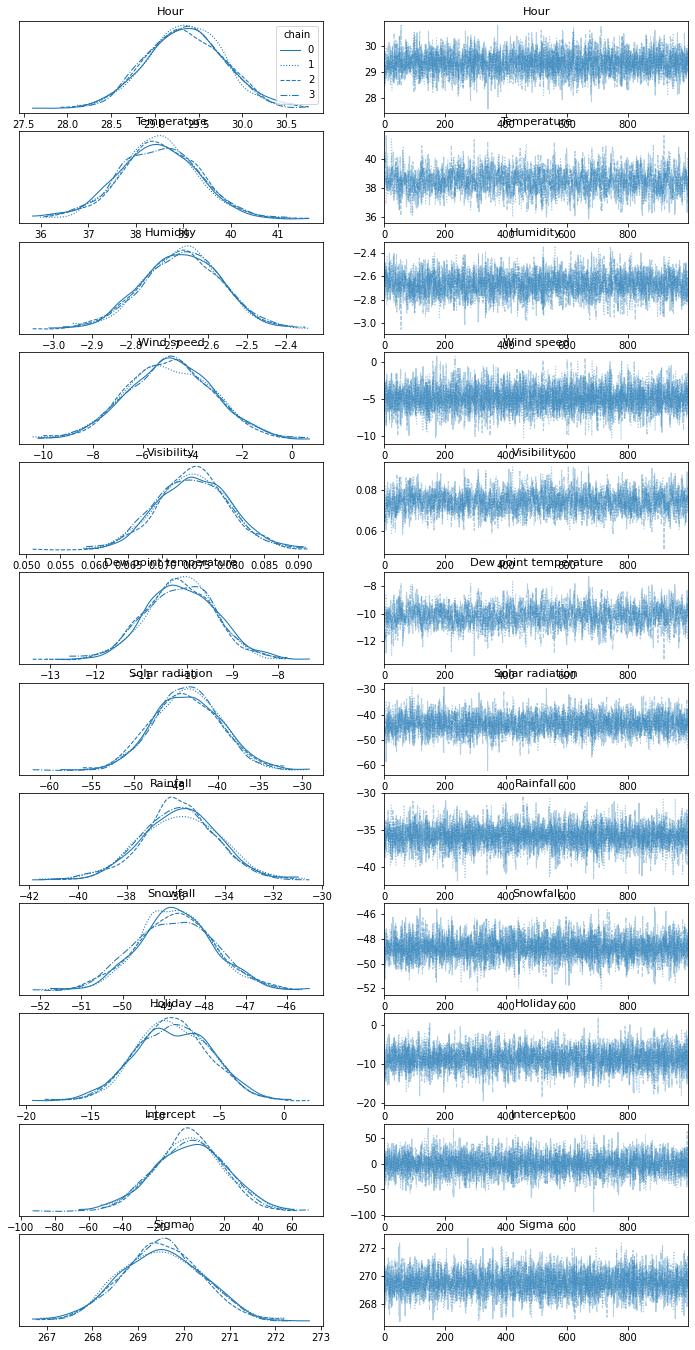

In [16]:
# Plots traces for posteriors
az.plot_trace(idata, combined=True)
az.plot_trace(idata,legend=True)

In [41]:
# Task 12 uses data to construct a linear regression model to 
# help answer whether data is suitable for linear regressin
from sklearn.linear_model import LinearRegression

# Linear regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg = LinearRegression().fit(X_train, Y_train)
print(reg.score(X_test, Y_test))

reg = LinearRegression().fit(X, Y)
print(reg.score(X, Y))

0.4651290510345685
0.4735252433404543


In [52]:
# Performs polynomial regression
from sklearn.preprocessing import PolynomialFeatures

# Poly regression with x^2
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_train)
reg_pol = LinearRegression()
reg_pol.fit(X_poly, Y_train)
print(reg_pol.score(poly_features.fit_transform(X_test), Y_test))

# Poly regression with x^3
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X_train)
reg_pol = LinearRegression()
reg_pol.fit(X_poly, Y_train)
print(reg_pol.score(poly_features.fit_transform(X_test), Y_test))

0.5585256055844121
0.6459555374210431
